In [515]:
# MTF073 Computational Fluid Dynamics
# Task 3: Pressure-velocity coupling
# Håkan Nilsson, 2023
# Department of Mechanics and Maritime Sciences
# Division of Fluid Dynamics
# Note that this is not efficient code. It is for educational purposes!

# The code assumes that the folder with data is in the same path as this file

# Clear all variables when running entire code:
from IPython import get_ipython
# get_ipython().run_line_magic('reset', '-sf')
# Packages needed
import numpy as np
import matplotlib.pyplot as plt
# Close all plots when running entire code:
plt.close('all')
# Set default font size in plots:
plt.rcParams.update({'font.size': 12})
import sys # For sys.exit()

#================= Inputs =====================

# Choice of case:
# Choose 'equidistant' or 'non-equidistant' for lid-driven cavity case.
# Choose 'coarse' or 'fine' for Task 2 case (and also choose caseID below).
mesh_type = 'non-equidistant'
mesh_type = 'coarse'

# Case inputs:
rho   =  1     # Density
mu    =  0.001 # Dynamic viscosity (calculated from Reynolds number Re = 1000)
# Specific for lid-driven cavity (over-ridden for Task 2 cases):
uWall =  1     # Velocity of the upper wall
L =  1         # length in X direction
H =  1         # length in Y direction
mI = 11        # number of mesh points X direction. 
mJ = 11        # number of mesh points Y direction.
# Specific for Task 2 cases (not used for lid-driven cavity):
caseID = 20     # Your Task 2 case number

# Solver inputs
linSol_pp      = 'Gauss-Seidel' # Either 'Gauss-Seidel' or 'TDMA'
scheme         = 'FOU_CD'       # Either 'FOU_CD' or 'Hybrid'
nIter          = 1000           # Maximum number of SIMPLE iterations
nLinSolIter_pp = 10             # Number of linear solver iterations for pp-equation
nLinSolIter_uv = 3              # Number of Gauss-Seidel iterations for u/v-equations
resTolerance   = 0.0000001        # Set convergence criteria for residuals
alphaUV        = 0.7            # Under-relaxation factor for u and v
alphaP         = 0.3            # Under-relaxation factor for p
RhieChow       = 'equiCorr'  # Either 'nonEquiCorr', 'equiCorr' or 'noCorr'
pRef_i = 1 # P=0 in some internal node (1..nI-2, not on boundary)
pRef_j = 1 # P=0 in some internal node (1..nJ-2, not on boundary)

# ================ Code =======================

# If case is from Task 2, read from files
# NO NEED TO CHANGE ANYTHING HERE
# IT JUST READS TASK 2 MESH (AND VELOCITY, TO SET BOUNDARY CONDITIONS)
# IT IS NOT USED IF THE CAVITY CASE IS CHOSEN
match mesh_type:
    case 'coarse' | 'fine':
        # Read grid and velocity data:
        match caseID:
            case 1 | 2 | 3 | 4 | 5:
                mesh_number = 1
            case 6 | 7 | 8 | 9 | 10:
                mesh_number = 2
            case 11 | 12 | 13 | 14 | 15:
                mesh_number = 3
            case 16 | 17 | 18 | 19 | 20:
                mesh_number = 4
            case 21 | 22 | 23 | 24 | 25:
                mesh_number = 5
            case _:
                sys.exit("No mesh for chosen caseID!")
        path = 'data/grid%d/%s_grid' % (mesh_number,mesh_type)
        pointXvector = np.genfromtxt('%s/xc.dat' % (path)) # x node coordinates
        pointYvector = np.genfromtxt('%s/yc.dat' % (path)) # y node coordinates
        # Reading velocities for setting boundary conditions later
        u_datavector = np.genfromtxt('%s/u.dat' % (path))  # u velocity at the nodes
        v_datavector = np.genfromtxt('%s/v.dat' % (path))  # v veloctiy at the nodes
        mI = len(pointXvector) # Number of mesh points X direction
        mJ = len(pointYvector) # Number of mesh points X direction
    case 'equidistant' | 'non-equidistant':
        pass
    case _:
        sys.exit("Improper mesh type!")

# Preparation of "nan", to fill empty slots in consistently numbered arrays.
# This makes it easier to check in Variable Explorer that values that should
# never be set are never set (or used). Plots simply omit nan values.
nan = float("nan")

# Allocate arrays (nan used to make clear where values need to be set)
# Note that some arrays could actually be 1D since they only have a variation
# in one direction, but they are kept 2D so the indexing is similar for all.
nI     = mI + 1                 # Number of nodes in X direction, incl. boundaries
nJ     = mJ + 1                 # Number of nodes in Y direction, incl. boundaries
pointX = np.zeros((mI,mJ))*nan  # X coords of the mesh points, in points
pointY = np.zeros((mI,mJ))*nan  # Y coords of the mesh points, in points
nodeX  = np.zeros((nI,nJ))*nan  # X coords of the nodes, in nodes
nodeY  = np.zeros((nI,nJ))*nan  # Y coords of the nodes, in nodes
dx_PE  = np.zeros((nI,nJ))*nan  # X distance to east node, in nodes
dx_WP  = np.zeros((nI,nJ))*nan  # X distance to west node, in nodes
dy_PN  = np.zeros((nI,nJ))*nan  # Y distance to north node, in nodes
dy_SP  = np.zeros((nI,nJ))*nan  # Y distance to south node, in nodes
dx_we  = np.zeros((nI,nJ))*nan  # X size of the control volume, in nodes
dy_sn  = np.zeros((nI,nJ))*nan  # Y size of the control volume, in nodes
aE_uv  = np.zeros((nI,nJ))*nan  # East coefficient for velocities, in nodes
aW_uv  = np.zeros((nI,nJ))*nan  # West coefficient for velocities, in nodes
aN_uv  = np.zeros((nI,nJ))*nan  # North coefficient for velocities, in nodes
aS_uv  = np.zeros((nI,nJ))*nan  # South coefficient for velocities, in nodes
aP_uv  = np.zeros((nI,nJ))  # Central coefficient for velocities, in nodes
Su_u   = np.zeros((nI,nJ))  # Source term for u-velocity, in nodes
Su_v   = np.zeros((nI,nJ))  # Source term for v-velocity, in nodes
aE_pp  = np.zeros((nI,nJ))*nan  # East coefficient for p', in nodes
aW_pp  = np.zeros((nI,nJ))*nan  # West coefficient for p', in nodes
aN_pp  = np.zeros((nI,nJ))*nan  # North coefficient for p', in nodes
aS_pp  = np.zeros((nI,nJ))*nan  # South coefficient for p', in nodes
aP_pp  = np.zeros((nI,nJ))  # Central coefficient for p', in nodes
Su_pp  = np.zeros((nI,nJ))  # Source term for p', in nodes
Sp_pp  = np.zeros((nI,nJ))  # Source term for p', in nodes
u      = np.zeros((nI,nJ))*nan  # U-velocity, in nodes
v      = np.zeros((nI,nJ))*nan  # V-velocity, in nodes
p      = np.zeros((nI,nJ))  # Pressure, in nodes (lower-case p)
pp     = np.zeros((nI,nJ))*nan  # Pressure correction, in nodes
De     = np.zeros((nI,nJ))*nan  # Diffusive coefficient for east face, in nodes
Dw     = np.zeros((nI,nJ))*nan  # Diffusive coefficient for west face, in nodes
Dn     = np.zeros((nI,nJ))*nan  # Diffusive coefficient for north face, in nodes
Ds     = np.zeros((nI,nJ))*nan  # Diffusive coefficient for south face, in nodes
Fe     = np.zeros((nI,nJ))*nan  # Convective coefficients for east face, in nodes
Fw     = np.zeros((nI,nJ))*nan  # Convective coefficients for west face, in nodes
Fn     = np.zeros((nI,nJ))*nan  # Convective coefficients for north face, in nodes
Fs     = np.zeros((nI,nJ))*nan  # Convective coefficients for south face, in nodes
de     = np.zeros((nI,nJ))  # Coefficient for east face, in nodes
dw     = np.zeros((nI,nJ))  # Coefficient for west face, in nodes
dn     = np.zeros((nI,nJ))  # Coefficient for north face, in nodes
ds     = np.zeros((nI,nJ))  # Coefficient for south face, in nodes
fxe    = np.zeros((nI,nJ))*nan  # Interpolation factor, in nodes
fxw    = np.zeros((nI,nJ))*nan  # Interpolation factor, in nodes
fyn    = np.zeros((nI,nJ))*nan  # Interpolation factor, in nodes
fys    = np.zeros((nI,nJ))*nan  # Interpolation factor, in nodes
P      = np.zeros((nI,nJ))*nan  # Array for TDMA, in nodes (upper-case P)
Q      = np.zeros((nI,nJ))*nan  # Array for TDMA, in nodes
outlet = np.zeros((nI,nJ))      # Array for marking outlets of Task 2 cases (zero by default)
res_u  = []                     # Array for appending u-residual each iteration
res_v  = []                     # Array for appending v-residual each iteration
res_c  = []                     # Array for appending continuity error each iteration

# If case is related to Task 2, prepare to use imported velocity field to set boundary conditions:
# NO NEED TO CHANGE ANYTHING HERE
# JUST REORGANIZING VELOCITY FIELD FOR TASK 2 CASES, TO FIGURE OUT BOUNDARY CONDITIONS
match mesh_type:
    case 'coarse' | 'fine':
        uTask2 = u_datavector.reshape(nI,nJ) # Task 2 values of x-velocity, in nodes
        vTask2 = v_datavector.reshape(nI,nJ) # Task 2 values of y-velocity, in nodes
        # Set Task 2 wall velocities to exactly zero:
        uTask2[uTask2 == 1e-10] = 0
        vTask2[vTask2 == 1e-10] = 0
    case 'equidistant' | 'non-equidistant':
        pass
    case _:
        sys.exit("Improper mesh type!")

# Generate mesh
match mesh_type:
    case 'equidistant':
        # Calculate mesh point coordinates:
        # Note that all entries of the array must be filled (no nan)
        # NO NEED TO CHANGE ANYTHING HERE. EQUIDISTANT MESH PROVIDED
        for i in range(0, mI):
            for j in range(0, mJ):
                pointX[i,j] = i*L/(mI - 1)
                pointY[i,j] = j*H/(mJ - 1)
    case 'non-equidistant':
         # Calculate mesh point coordinates with stretching
        stretch = 1.15
        t_stretch = np.tanh(stretch)
        pointX[0,:] = 0
        pointY[:,0] = 0
        for i in range(1, mI):
            z2dp_x = ((2*i+1) - mI)/mI
            pointX[i,:] = (1 + np.tanh(stretch*z2dp_x)/t_stretch) * 0.5 * L
            
        for j in range(1, mJ):
            z2dp_y = ((2*j+1) - mJ)/mJ
            pointY[:,j] = (1 + np.tanh(stretch*z2dp_y)/t_stretch) * 0.5 * H
        pointX[-1,:] = L
        pointY[:,-1] = H
        
    case 'coarse' | 'fine':
        # Set point coordinates:
        # NO NEED TO CHANGE ANYTHING HERE. CREATES MESH FOR TASK 2 CASES
        for i in range(0, mI):
            for j in range(0, mJ):
                pointX[i,j] = pointXvector[i]
                pointY[i,j] = pointYvector[j]
        # Calculate length and height:
        L = pointX[mI-1,0] - pointX[0,0]
        H = pointY[0,mJ-1] - pointY[0,0]
    case _:
        sys.exit("Improper mesh type!")


In [516]:

# Calculate node coordinates (same for equidistant and non-equidistant):
# NO NEED TO CHANGE ANYTHING HERE
# PROVIDED FOR YOU, SO YOU CAN PLOT THE MESH IMMEDIATELY
# Internal nodes:
for i in range(0, nI):
    for j in range(0, nJ):
        if i > 0 and i < nI-1:
            nodeX[i,j] = 0.5*(pointX[i,0] + pointX[i-1,0])
        if j > 0 and j < nJ-1:
            nodeY[i,j] = 0.5*(pointY[0,j] + pointY[0,j-1])
# Boundary nodes:
nodeX[0,:]  = pointX[0,0]  # Note: corner points needed for contour plot
nodeY[:,0]  = pointY[0,0]  # Note: corner points needed for contour plot
nodeX[-1,:] = pointX[-1,0] # Note: corner points needed for contour plot
nodeY[:,-1] = pointY[0,-1] # Note: corner points needed for contour plot

# Calculate distances
# Keep 'nan' where values are not needed!
for i in range(1, nI-1):
    for j in range(1, nJ-1):
        dx_PE[i,j] = nodeX[i+1,j] - nodeX[i,j]
        dx_WP[i,j] = nodeX[i,j] - nodeX[i-1,j]
        dy_PN[i,j] = nodeY[i,j+1] - nodeY[i,j]
        dy_SP[i,j] = nodeY[i,j] - nodeY[i,j-1]
        dx_we[i,j] = pointX[i,j] - pointX[i-1,j]
        dy_sn[i,j] = pointY[i,j] - pointY[i,j-1]


In [517]:

# Calculate interpolation factors
# Keep 'nan' where values are not needed!
for i in range(1, nI-1):
    for j in range(1, nJ-1):
        fxe[i,j] = 0.5*dx_we[i,j] / dx_PE[i,j]
        fxw[i,j] = 0.5*dx_we[i,j] / dx_WP[i,j]
        fyn[i,j] = 0.5*dy_sn[i,j] / dy_PN[i,j]
        fys[i,j] = 0.5*dy_sn[i,j] / dy_SP[i,j]

# Constant contributions to mom.eq. discretization:
# Keep 'nan' where values are not needed!
for i in range (1,nI-1):
    for j in range(1,nJ-1):
        De[i,j] = dy_sn[i,j]*mu/dx_PE[i,j]
        Dw[i,j] = dy_sn[i,j]*mu/dx_WP[i,j]
        Dn[i,j] = dx_we[i,j]*mu/dy_PN[i,j]
        Ds[i,j] = dx_we[i,j]*mu/dy_SP[i,j]
        

In [518]:

# Initialize dependent variable arrays and Dirichlet boundary conditions
# Note that a value is needed in all nodes for contour plot
# NO NEED TO CHANGE ANYTHING HERE. SETS INITIAL AND (INITIAL) BOUNDARY CONDITIONS
# EASY FOR CAVITY, BUT A BIT TRICKY FOR TASK 2 CASES, WHICH IS WHY IT IS PROVIDED
# Default:
u[:,:] = 0
v[:,:] = 0
p[:,:] = 0
# Set initial default face fluxes
Fe[1:nI-1, 1:nJ-1] = 0
Fw[1:nI-1, 1:nJ-1] = 0
Fn[1:nI-1, 1:nJ-1] = 0
Fs[1:nI-1, 1:nJ-1] = 0
# Boundary conditions:
match mesh_type:
    case 'equidistant' | 'non-equidistant':
        # Top wall:
        u[:,nJ-1] = uWall
    case 'coarse' | 'fine':
        # Get ONLY BOUNDARY velocity and face fluxes from imported data
        for i in range(1,nI-1):
            u[i,0] = uTask2[i,0]
            v[i,0] = vTask2[i,0]
            u[i,nJ-1] = uTask2[i,nJ-1]
            v[i,nJ-1] = vTask2[i,nJ-1]
            Fs[i,1] = v[i,0]*rho*dx_we[i,1]
            Fn[i,nJ-2] = v[i,nJ-1]*rho*dx_we[i,nJ-2]
        for j in range(1,nJ-1):
            u[0,j] = uTask2[0,j]
            v[0,j] = vTask2[0,j]
            u[nI-1,j] = uTask2[nI-1,j]
            v[nI-1,j] = vTask2[nI-1,j]
            Fw[1,j] = u[0,j]*rho*dy_sn[1,j]
            Fe[nI-2,j] = u[nI-1,j]*rho*dy_sn[nI-2,j]
        # Mark outlets (particular for Task 2 cases):
        for i in range (1,nI-1):
            if v[i,0] < 0:
                outlet[i,0] = 1
            if v[i,nJ-1] > 0:
                outlet[i,nJ-1] = 1
        for j in range (1,nJ-1):
            if u[0,j] < 0:
                outlet[0,j] = 1
            if u[nI-1,j] > 0:
                outlet[nI-1,j] = 1
        # Just for checking (not used or printed):
        globContErr = np.sum(Fe[nI-2,1:nJ-1]) - np.sum(Fw[1,1:nJ-1]) + \
                      np.sum(Fn[1:nI-1,nJ-2]) - np.sum(Fs[1:nI-1,1])
    case _:
        sys.exit("Improper mesh type!")
        

In [519]:
ue = np.zeros_like(u)
uw = np.zeros_like(u)
vn = np.zeros_like(u)
vs = np.zeros_like(u)
# for i in range(1,nI-1):
#     for j in range(1,nJ-1):
#         ue[i,j] = (u[i+1,j]*fxe[i,j] +(1-fxe[i,j])*u[i,j])
#         uw[i,j] = (u[i-1,j]*fxw[i,j] +(1-fxw[i,j])*u[i,j])
#         vn[i,j] = (v[i,j+1]*fyn[i,j] +(1-fyn[i,j])*v[i,j])
#         vs[i,j] = (v[i,j-1]*fys[i,j] +(1-fys[i,j])*v[i,j])

for iter in range(nIter):

    # Momentum equation coefficients
    # FOR TASK 2 CASES, MAKE SURE TO TREAT INLETS/OUTLETS CORRECTLY
    # (USE THE outlet ARRAY TO IDENTIFY WHERE OUTLETS ARE LOCATED)
    # NEGLECT CONTINUITY ERROR IN CENTRAL COEFFICIENT!

    match scheme:
        case 'FOU_CD':
            for i in range(1,nI-1):
                for j in range(1,nJ-1):
                    aE_uv[i,j] = De[i,j] + max([-fxe[i,j]*Fe[i,j], 0])
                    aW_uv[i,j] = Dw[i,j] + max([fxw[i,j]*Fw[i,j], 0])
                    aN_uv[i,j] = Dn[i,j] + max([-fyn[i,j]*Fn[i,j], 0])
                    aS_uv[i,j] = Ds[i,j] + max([fys[i,j]*Fs[i,j], 0])
                    aP_uv[i,j] = (aE_uv[i,j] + aW_uv[i,j] + aN_uv[i,j] + aS_uv[i,j])  / alphaUV
        case 'Hybrid':
            for i in range(1,nI-1):
                for j in range(1,nJ-1):
                    aE_uv[i,j] = max([-Fe[i,j],De[i,j]-fxe[i,j]*Fe[i,j], 0])
                    aW_uv[i,j] = max([Fw[i,j],Dw[i,j]+fxw[i,j]*Fw[i,j], 0])
                    aN_uv[i,j] = max([-Fn[i,j],Dn[i,j]-fyn[i,j]*Fn[i,j], 0])
                    aS_uv[i,j] = max([Fs[i,j],Ds[i,j]+fys[i,j]*Fs[i,j], 0])
                    aP_uv[i,j] = (aE_uv[i,j] + aW_uv[i,j] + aN_uv[i,j] + aS_uv[i,j]) / alphaUV 
        case _:
            sys.exit("Improper scheme!")

    # Momentum equation source terms and implicit under-relaxation
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            # ta väggarna och cellwidth inste
            Su_u[i,j] = 1/(dx_WP[i,j] + dx_PE[i,j])*(p[i-1,j]-p[i+1,j])*dy_sn[i,j]*dx_we[i,j] + ((1-alphaUV)*aP_uv[i,j])*u[i,j]
            Su_v[i,j] = 1/(dy_SP[i,j] + dy_PN[i,j])*(p[i,j-1]-p[i,j+1])*dx_we[i,j]*dy_sn[i,j] + ((1-alphaUV)*aP_uv[i,j])*v[i,j]

    # Solve u-mom. eq. a number of Gauss-Seidel loops:
    # JUST ADAPT YOUR GAUSS-SEIDEL SOLVER FROM TASK 2
    for linSolIter in range(nLinSolIter_uv):  
        for i in range(1,nI-1):
            for j in range(1,nJ-1): 
                u[i, j] = (aW_uv[i, j] * u[i - 1, j] + aE_uv[i, j] * u[i + 1, j] + aS_uv[i, j] \
                         * u[i, j - 1] + aN_uv[i, j] * u[i, j + 1] + Su_u[i,j] ) / (aP_uv[i, j])

    # Solve v-mom. eq. a number of Gauss-Seidel loops:
    # JUST ADAPT YOUR GAUSS-SEIDEL SOLVER FROM TASK 2
    for linSolIter in range(nLinSolIter_uv):   
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                v[i, j] = (aW_uv[i, j] * v[i - 1, j] + aE_uv[i, j] * v[i + 1, j] + aS_uv[i, j] \
                        * v[i, j - 1] + aN_uv[i, j] * v[i, j + 1] + Su_v[i,j] ) / (aP_uv[i, j])



    # Update OUTLET velocity and face fluxes for Task 2 cases only:
    # NO NEED TO CHANGE ANYTHING HERE
    # IT IS A BIT COMPLEX, WHICH IS WHY IT IS PROVIDED
    # PLEASE HAVE A LOOK AT IT AND DESCRIBE IN THE REPORT WHAT IS DONE!
    # PLEASE SUGGEST A NICER IMPLEMENTATION (OPTIONAL)
    # BOUNDARY CONDITIONS FOR THE CAVITY CASE DOES NOT CHANGE, AND NEEDS NO UPDATE
    match mesh_type:
        case 'equidistant' | 'non-equidistant':
            pass
        case 'coarse' | 'fine':
            # Zero gradient for velocity at outlet, and calculate outlet face fluxes
            for i in range (1,nI-1):
                if outlet[i,0] == 1:
                    u[i,0] = u[i,1]
                    v[i,0] = v[i,1]
                    Fs[i,1] = rho*v[i,0]*dx_we[i,1]
                if outlet[i,nJ-1] == 1:
                    u[i,nJ-1] = u[i,nJ-2]
                    v[i,nJ-1] = v[i,nJ-2]
                    Fn[i,nJ-2] = rho*v[i,nJ-1]*dx_we[i,nJ-2]
            for j in range (1,nJ-1):
                if outlet[0,j] == 1:
                    u[0,j] = u[1,j]
                    v[0,j] = v[1,j]
                    Fw[1,j] = rho*u[0,j]*dy_sn[1,j]
                if outlet[nI-1,j] == 1:
                    u[nI-1,j] = u[nI-2,j]
                    v[nI-1,j] = v[nI-2,j]
                    Fe[nI-2,j] = rho*u[nI-1,j]*dy_sn[nI-2,j]
            # Correct outlet face fluxes to get global continuity
            inletFlux = - np.sum((1-outlet[nI-1,1:nJ-1]) * Fe[nI-2,1:nJ-1]) \
                        + np.sum((1-outlet[0,1:nJ-1]) * Fw[1,1:nJ-1]) \
                        - np.sum((1-outlet[1:nI-1,nJ-1]) * Fn[1:nI-1,nJ-2]) \
                        + np.sum((1-outlet[1:nI-1,0]) * Fs[1:nI-1,1])
            outletFlux =   np.sum(outlet[nI-1,1:nJ-1] * Fe[nI-2,1:nJ-1]) \
                         - np.sum(outlet[0,1:nJ-1] * Fw[1,1:nJ-1]) \
                         + np.sum(outlet[1:nI-1,nJ-1] * Fn[1:nI-1,nJ-2]) \
                         - np.sum(outlet[1:nI-1,0] * Fs[1:nI-1,1])
            # Must initialize first SIMPLE iteration (since outlet velocites are zero):
            if outletFlux == 0:
                outletArea = np.sum(outlet[nI-1,1:nJ-1]*dy_sn[nI-2,1:nJ-1]) + \
                             np.sum(outlet[0,1:nJ-1]*dy_sn[1,1:nJ-1]) + \
                             np.sum(outlet[1:nI-1,nJ-1]*dy_sn[1:nI-1,nJ-2]) + \
                             np.sum(outlet[1:nI-1,0]*dy_sn[1:nI-1,1])
                for i in range (1,nI-1):
                    if outlet[i,0] == 1:
                        Fs[i,1] = -inletFlux*dx_we[i,1]/outletArea
                    if outlet[i,nJ-1] == 1:
                        Fn[i,nJ-2] = inletFlux*dx_we[i,nJ-2]/outletArea
                for j in range (1,nJ-1):
                    if outlet[0,j] == 1:
                        Fw[1,j] = -inletFlux*dy_sn[1,j]/outletArea
                    if outlet[nI-1,j] == 1:
                        Fe[nI-2,j] = inletFlux*dy_sn[nI-2,j]/outletArea
            # For all other SIMPLE iterations:
            else:
                for i in range (1,nI-1):
                    if outlet[i,0] == 1:
                        Fs[i,1] *= inletFlux/outletFlux
                    if outlet[i,nJ-1] == 1:
                        Fn[i,nJ-2] *= inletFlux/outletFlux
                for j in range (1,nJ-1):
                    if outlet[0,j] == 1:
                        Fw[1,j] *= inletFlux/outletFlux
                    if outlet[nI-1,j] == 1:
                        Fe[nI-2,j] *= inletFlux/outletFlux
            globContErr = np.sum(Fe[nI-2,1:nJ-1]) - np.sum(Fw[1,1:nJ-1]) + \
                          np.sum(Fn[1:nI-1,nJ-2]) - np.sum(Fs[1:nI-1,1])
        case _:
            sys.exit("Improper mesh type!")
    
    # Calculate face fluxes using Rhie & Chow (or not Rhie & Chow)
    # DO NOT TOUCH BOUNDARY FLUXES, WHICH ARE SET WITH BOUNDARY CONDITIONS!
    # A RHIE & CHOW CORRECTION TERM BASED ON EQUIDISTANT MESH AND
    # CONSTANT aP_uv GIVES MORE SIMILAR RESULTS AS REFERENCE DATA,
    # BUT YOU SHOULD (ALSO) IMPLEMENT IT FOR A NON-EQUIDISTANT MESH (COMPULSORY)
    # ALSO IMPLEMENT WITHOUT RHIE & CHOW, TO SEE CHECKERBOARD IN TASK 2 CASES
    # THE BASE INTERPOLATION SHOULD ALWAYS BE FOR A NON-EQUIDISTANT MESH!
    u_d = np.zeros_like(u)
    v_d = np.zeros_like(v)
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            de[i,j] = dy_sn[i,j] / (fxe[i,j]*(aP_uv[i+1,j] - aP_uv[i,j]) + aP_uv[i,j])
            dw[i,j] = dy_sn[i,j] / (fxw[i,j]*(aP_uv[i-1,j] - aP_uv[i,j]) + aP_uv[i,j])
            dn[i,j] = dx_we[i,j] / (fyn[i,j]*(aP_uv[i,j+1] - aP_uv[i,j]) + aP_uv[i,j])
            ds[i,j] = dx_we[i,j] / (fys[i,j]*(aP_uv[i,j-1] - aP_uv[i,j]) + aP_uv[i,j])
            if j == 1:
                ds[i,j] = 0
            if j == nJ-2:
                dn[i,j] = 0
            if i ==  1:
                dw[i,j] = 0
            if i == nI -2:
                de[i,j] = 0

            u_d[i,j] = u[i,j] + 1/aP_uv[i,j] * ((p[i+1,j] - p[i-1,j])/(dx_WP[i,j] + dx_PE[i,j])) * dx_we[i,j] * dy_sn[i,j]
            v_d[i,j] = v[i,j] + 1/aP_uv[i,j] * ((p[i,j+1] - p[i,j-1])/(dy_PN[i,j] + dy_SP[i,j])) * dx_we[i,j] * dy_sn[i,j]
    match RhieChow:

        case 'noCorr':
            for i in range(1,nI-1):
                for j in range(1,nJ-1):
                    ue[i,j] = (u[i+1,j]*fxe[i,j] +(1-fxe[i,j])*u[i,j])
                    uw[i,j] = (u[i-1,j]*fxw[i,j] +(1-fxw[i,j])*u[i,j])
                    vn[i,j] = (v[i,j+1]*fyn[i,j] +(1-fyn[i,j])*v[i,j])
                    vs[i,j] = (v[i,j-1]*fys[i,j] +(1-fys[i,j])*v[i,j])
            
            # No Rhie & Chow correction:
            # Easiest to implement, so start with this.
            # Actually gives good comparison with reference data for cavity case.
            # Gives slightly fluctuating fields for cavity, and checkerboarding for Task 2 cases.
        case 'equiCorr':
            # Equidistant implementation of correction term:
            # Gives best comparison with reference data (which may have been derived like this).

            for i in range(1,nI-1):
                for j in range(1,nJ-1):

                    if i != nI-2:
                        ue[i,j] = 0.5*(u[i+1,j] + u[i,j]) + de[i,j]/4*(p[i+2,j]-3*p[i+1,j]+3*p[i,j]-p[i-1,j])

                    if i != 1:
                        uw[i,j] = 0.5*(u[i-1,j] + u[i,j]) + dw[i,j]/4*(p[i+1,j]-3*p[i,j]+3*p[i-1,j]-p[i-2,j])
                    
                    if j != nJ-2:
                        vn[i,j] = 0.5*(v[i,j+1] + v[i,j]) + dn[i,j]/4*(p[i,j+2]-3*p[i,j+1]+3*p[i,j]-p[i,j-1])
                    
                    if j != 1:
                        vs[i,j] = 0.5*(v[i,j-1] + v[i,j]) + ds[i,j]/4*(p[i,j+1]-3*p[i,j]+3*p[i,j-1]-p[i,j-2])
                    

        

        case 'nonEquiCorr':

            for i in range(1,nI-1):
                for j in range(1,nJ-1):
                    if i != nI-2:
                        u_de = (u_d[i+1,j]*fxe[i,j] + (1-fxe[i,j])*u_d[i,j])
                        ap_e = (aP_uv[i+1,j]*fxe[i,j] + (1-fxe[i,j])*aP_uv[i,j])
                        ue[i,j] = u_de - (p[i+1,j]-p[i,j])/dx_PE[i,j] * ((dx_we[i,j]*dy_sn[i,j])/(ap_e))
                   
                    if i != 1:
                        u_dw = (u_d[i-1,j]*fxw[i,j] +(1-fxw[i,j])*u_d[i,j])
                        ap_w = (aP_uv[i-1,j]*fxw[i,j] +(1-fxw[i,j])*aP_uv[i,j])
                        uw[i,j] = u_dw - ((p[i,j] - p[i-1,j])/dx_WP[i,j]) * ((dx_we[i,j]*dy_sn[i,j])/(ap_w))
                    
                    if j != nJ-2:
                        v_dn = (v_d[i,j+1]*fyn[i,j] +(1-fyn[i,j])*v_d[i,j])
                        ap_n = (aP_uv[i,j+1]*fyn[i,j] +(1-fyn[i,j])*aP_uv[i,j])
                        vn[i,j] = v_dn - ((p[i,j+1] - p[i,j])/dy_PN[i,j]) * ((dx_we[i,j]*dy_sn[i,j])/(ap_n))
                    
                    if j != 1:
                        v_ds = (v_d[i,j-1]*fys[i,j] +(1-fys[i,j])*v_d[i,j])
                        ap_s = (aP_uv[i,j-1]*fys[i,j] +(1-fys[i,j])*aP_uv[i,j])
                        vs[i,j] = v_ds - ((p[i,j] - p[i,j-1])/dy_SP[i,j]) * ((dx_we[i,j]*dy_sn[i,j])/(ap_s))
                    
                    
            # Non-equidistant implementation of everything:
            # Gives ok comparison with reference data.
        case _:
            sys.exit("Improper RhieChow choice!")

    # Calculate pressure correction equation coefficients and source term
    # Make sure to treat boundary conditions correctly!
    # Note that de, dw, dn, ds are useful also later, so make sure to keep them.
   

    pp[:,:] = 0
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            aE_pp[i,j] = de[i,j] * rho * dy_sn[i,j]
            aW_pp[i,j] = dw[i,j] * rho * dy_sn[i,j]
            aN_pp[i,j] = dn[i,j] * rho * dx_we[i,j]
            aS_pp[i,j] = ds[i,j] * rho * dx_we[i,j]
            if i != nI-2:
                Fe[i,j] = rho  * dy_sn[i,j] * ue[i,j]
            if i != 1:
                Fw[i,j] = rho  * dy_sn[i,j] * uw[i,j]
            if j != nJ-2:
                Fn[i,j] = rho  * dx_we[i,j] * vn[i,j]
            if j != 1:
                Fs[i,j] = rho  * dx_we[i,j] * vs[i,j]
            Su_pp[i,j] = -(Fe[i,j]-Fw[i,j] + Fn[i,j]-Fs[i,j]) # b'

            aP_pp[i,j] = aE_pp[i,j] + aW_pp[i,j] + aN_pp[i,j] + aS_pp[i,j]

    # Fix pressure by forcing pp to zero, through source terms:
    # MAKES CONVERGENCE POOR, SO BETTER TO SKIP IT FOR NOW. TRY IF YOU LIKE
    # Su_pp[pRef_i,pRef_j] = pow(10,30) * 0.0
    # aP_pp[pRef_i,pRef_j] = aE_pp[pRef_i,pRef_j] + aW_pp[pRef_i,pRef_j] + aN_pp[pRef_i,pRef_j] + aS_pp[pRef_i,pRef_j] - (-pow(10,30))

    # Solve pressure correction equation
    
    match linSol_pp:
        case 'Gauss-Seidel':
            # JUST ADAPT YOUR Gauss-Seidel SOLVER FROM TASK 2
            for linSolIter in range(nLinSolIter_pp):
                for i in range(1,nI-1):
                    for j in range(1,nJ-1):
                        pp[i, j] = (aW_pp[i, j] * pp[i - 1, j] + aE_pp[i, j] * pp[i + 1, j] + aS_pp[i, j] \
                                    * pp[i, j - 1] + aN_pp[i, j] * pp[i, j + 1] + Su_pp[i,j] ) / aP_pp[i, j]


        case 'TDMA':
            # JUST ADAPT YOUR TDMA SOLVER FROM TASK 2
            for linSolIter in range(nLinSolIter_pp):
                a = np.zeros([nI,nJ])
                b = np.zeros([nI,nJ])
                c = np.zeros([nI,nJ])
                d = np.zeros([nI,nJ])
                P = np.zeros([nI,nJ])
                Q = np.zeros([nI,nJ])
                #Solve horizontally
                if linSolIter%2 ==0:
                    for j in range(1,nJ-1):
                        for i in range(1,nI-1):
                            a[i,j] = aP_pp[i,j]  
                            b[i,j] = aE_pp[i,j]  
                            c[i,j] = aW_pp[i,j]  
                            d[i,j] = aN_pp[i,j]*pp[i,j+1] + aS_pp[i,j] * pp[i,j-1] + Su_pp[i,j]
                        #Construct P and Q terms
                        i = 1
                        P[i,j] = b[i,j] / a[i,j]
                        Q[i,j] = (d[i,j] + c[i,j] * pp[i-1,j])/a[i,j] 
                        for i in range(2,nI-2):
                            P[i,j] = b[i,j] / (a[i,j] - c[i,j] * P[i-1,j])
                            Q[i,j] = (d[i,j] + c[i,j] * Q[i-1,j]) / (a[i,j] - c[i,j] * P[i-1,j])
                        i=nI-2
                        P[i,j] = 0
                        Q[i,j] = (d[i,j] + c[i,j] * Q[i-1,j] + b[i,j] * pp[i+1,j]) / (a[i,j] - c[i,j] * P[i-1,j])

                        for i in reversed(range(1, nI-1)):
                            pp[i,j] = P[i,j] * pp[i+1,j] + Q[i,j]

                else: # Solve vertically
                    for i in range(1,nI-1):
                        for j in range(1,nJ-1):
                            a[i,j] = aP_pp[i,j]  
                            b[i,j] = aN_pp[i,j]  
                            c[i,j] = aS_pp[i,j]  
                            d[i,j] = aE_pp[i,j]*pp[i+1,j] + aW_pp[i,j] * pp[i-1,j] + Su_pp[i,j]
                        #Construct P and Q terms
                        j = 1
                        P[i,j] = b[i,j] / a[i,j]
                        Q[i,j] = (d[i,j] + c[i,j] * pp[i,j-1])/a[i,j] 
                        for j in range(2,nJ-2):
                            P[i,j] = b[i,j] / (a[i,j] - c[i,j] * P[i,j-1])
                            Q[i,j] = (d[i,j] + c[i,j] * Q[i,j-1]) / (a[i,j] - c[i,j] * P[i,j-1])
                        j=nJ-2
                        P[i,j] = 0
                        Q[i,j] = (d[i,j] + c[i,j] * Q[i,j-1] + b[i,j] * pp[i,j+1]) / (a[i,j] - c[i,j] * P[i,j-1])

                        for j in reversed(range(1, nJ-1)):
                            pp[i,j] = P[i,j] * pp[i,j+1] + Q[i,j]
        case _:
            sys.exit("Improper linSolPp!")
                    
    # Set pressure correction (and pressure level) explicitly
    # NO NEED TO CHANGE ANYTHING HERE
    pp[:,:] -= pp[pRef_i,pRef_j]
    # Correct pressure correction homogeneous Neumann boundary conditions
    pp[:,0] = pp[:,1]
    pp[:,-1] = pp[:,-2]
    pp[0,:] = pp[1,:]
    pp[-1,:] = pp[-2,:]

    # Correct pressure, using explicit under-relaxation
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            p[i,j] = p[i,j] + alphaP*pp[i,j]

    # Extrapolate pressure to boundaries, using constant gradient,
    # required to get correct Suu in u-mom. equation!
    for i in range(1,nI-1):
        j = 0
        p[i,j] = p[i,j+1] + dy_SP[i,j+1]* (p[i,j+1] - p[i,j+2])/dy_PN[i,j+1]
        j = -1
        p[i,j] = p[i,j-1] + dy_PN[i,j-1]* (p[i,j-1] - p[i,j-2])/dy_SP[i,j-1]
    for j in range(1,nJ-1):
        i = 0
        p[i,j] = p[i+1,j] + dx_WP[i+1,j]* (p[i+1,j] - p[i+2,j])/dx_PE[i+1,j]
        i = -1
        p[i,j] = p[i-1,j] + dx_PE[i-1,j]* (p[i-1,j] - p[i-2,j])/dx_WP[i-1,j]
    # Interpolate pressure to corners


    p[0,0]   = np.mean([p[1,0],p[1,1],p[0,1]])
    p[-1,0]  = np.mean([p[-2,0],p[-2,1],p[-1,1]])
    p[0,-1]  = np.mean([p[1,-2],p[1,-1],p[0,-2]])
    p[-1,-1] = np.mean([p[-1,-2],p[-2,-1],p[-2,-2]])

    


    # Correct face fluxes using pp solution (DO NOT TOUCH BOUNDARIES!)
    for i in range(1,nI-1):
        for j in range(1,nJ-1):  
            ue[i,j] = ue[i,j] + de[i,j]*(pp[i,j]-pp[i+1,j])
            uw[i,j] = uw[i,j] + dw[i,j]*(pp[i-1,j]-pp[i,j])
            vn[i,j] = vn[i,j] + dn[i,j]*(pp[i,j]-pp[i,j+1])
            vs[i,j] = vs[i,j] + ds[i,j]*(pp[i,j-1]-pp[i,j])
            
            if i != nI-2:
                Fe[i,j] = rho  * dy_sn[i,j] * ue[i,j]
            if i != 1:
                Fw[i,j] = rho  * dy_sn[i,j] * uw[i,j]
            if j != nJ-2:
                Fn[i,j] = rho  * dx_we[i,j] * vn[i,j]
            if j != 1:
                Fs[i,j] = rho  * dx_we[i,j] * vs[i,j]
    


    # Correct velocity components using pp solution (DO NOT TOUCH BOUNDARIES!)
    for i in range(1,nI-1):
        for j in range(1,nJ-1):  
            du = dy_sn[i,j] / aP_uv[i,j]
            dv = dx_we[i,j] / aP_uv[i,j] 
            ppe = (pp[i+1,j]*fxe[i,j] + (1-fxe[i,j])*pp[i,j])
            ppw = (pp[i-1,j]*fxw[i,j] + (1-fxw[i,j])*pp[i,j])
            ppn = (pp[i,j+1]*fyn[i,j] + (1-fyn[i,j])*pp[i,j])
            pps = (pp[i,j-1]*fys[i,j] + (1-fys[i,j])*pp[i,j])

            u[i,j] = u[i,j] + du*(ppw-ppe)
            v[i,j] = v[i,j] + dv*(pps-ppn)  
    
    
    # Compute residuals
    F = 1
    res_u.append(0) # U momentum residual
    res_v.append(0) # V momentum residual
    res_c.append(0) # Continuity residual
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
 
            res_u[-1] += 1/F*abs(aP_uv[i,j]*u[i,j] - (aE_uv[i,j]*u[i+1,j] + aW_uv[i,j]*u[i-1,j] + aS_uv[i,j]*u[i,j-1] + aN_uv[i,j]*u[i,j+1] + Su_u[i,j]))
                
            res_v[-1] += 1/F*abs(aP_uv[i,j]*v[i,j] - (aE_uv[i,j]*v[i+1,j] + aW_uv[i,j]*v[i-1,j] + aS_uv[i,j]*v[i,j-1] + aN_uv[i,j]*v[i,j+1] + Su_v[i,j]))
            
            res_c[-1] += abs(Su_pp[i,j])

    print('Iter: %5d, resU = %.5e, resV = %.5e, resCon = %.5e'\
        % (iter, res_u[-1], res_v[-1], res_c[-1]))

    #  Check convergence
    # if iter > 1: break
    if max([res_u[-1], res_v[-1], res_c[-1]]) < resTolerance:
        break


/var/folders/22/q9sp07116yn8szmswxprfhz40000gn/T/ipykernel_97897/2018575892.py:147: RuntimeWarning: divide by zero encountered in scalar divide
  dw[i,j] = dy_sn[i,j] / (fxw[i,j]*(aP_uv[i-1,j] - aP_uv[i,j]) + aP_uv[i,j])
/var/folders/22/q9sp07116yn8szmswxprfhz40000gn/T/ipykernel_97897/2018575892.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  ds[i,j] = dx_we[i,j] / (fys[i,j]*(aP_uv[i,j-1] - aP_uv[i,j]) + aP_uv[i,j])
/var/folders/22/q9sp07116yn8szmswxprfhz40000gn/T/ipykernel_97897/2018575892.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  dn[i,j] = dx_we[i,j] / (fyn[i,j]*(aP_uv[i,j+1] - aP_uv[i,j]) + aP_uv[i,j])


Iter:     0, resU = 1.53152e-01, resV = 3.49629e-01, resCon = 1.39196e+00
Iter:     1, resU = 7.16312e-01, resV = 1.37706e+00, resCon = 3.23324e+00
Iter:     2, resU = 3.69728e-01, resV = 8.12067e-01, resCon = 2.93229e+00
Iter:     3, resU = 2.19860e-01, resV = 4.67257e-01, resCon = 2.25911e+00
Iter:     4, resU = 1.63526e-01, resV = 3.26327e-01, resCon = 1.74696e+00
Iter:     5, resU = 1.39749e-01, resV = 2.92747e-01, resCon = 1.52230e+00
Iter:     6, resU = 1.21898e-01, resV = 2.53068e-01, resCon = 1.47861e+00
Iter:     7, resU = 1.20548e-01, resV = 2.12822e-01, resCon = 1.47990e+00
Iter:     8, resU = 1.14109e-01, resV = 1.76885e-01, resCon = 1.47517e+00
Iter:     9, resU = 1.04816e-01, resV = 1.48052e-01, resCon = 1.37077e+00
Iter:    10, resU = 1.01811e-01, resV = 1.28094e-01, resCon = 1.16040e+00
Iter:    11, resU = 1.00365e-01, resV = 1.14328e-01, resCon = 9.46650e-01
Iter:    12, resU = 9.81684e-02, resV = 9.89208e-02, resCon = 7.98231e-01
Iter:    13, resU = 9.61881e-02, resV 

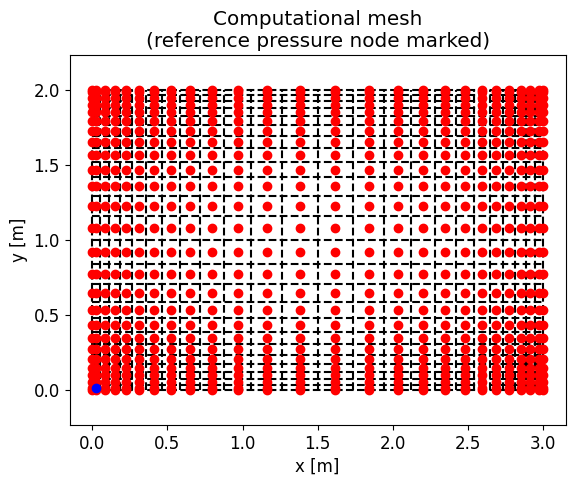

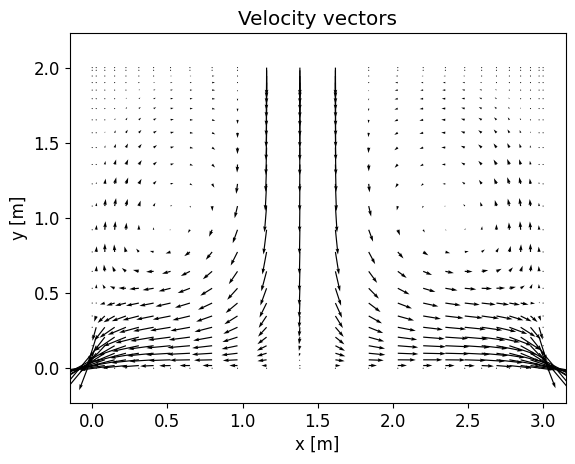

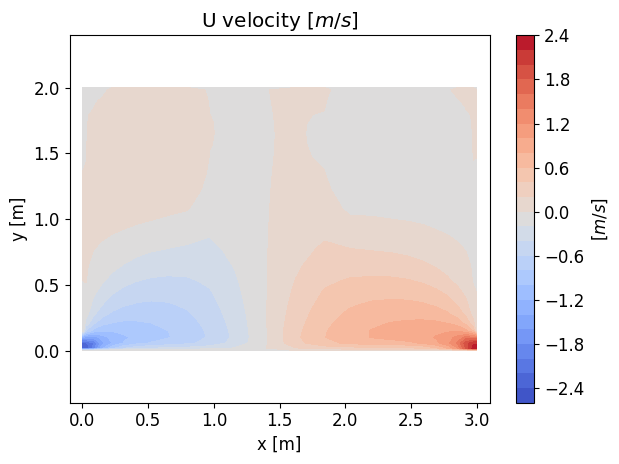

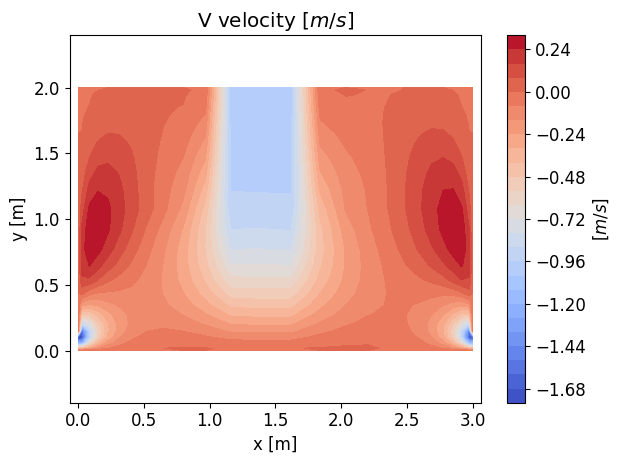

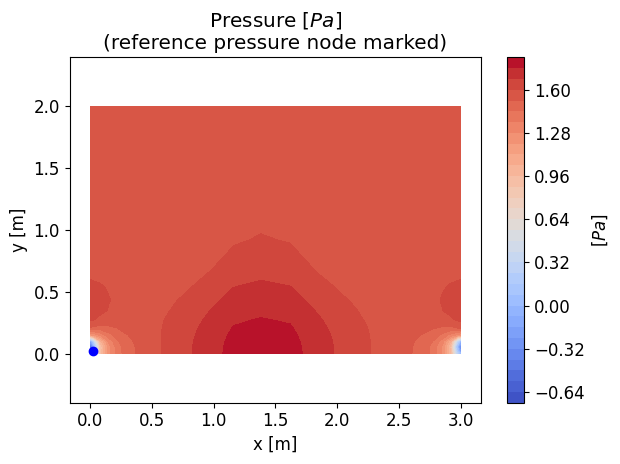

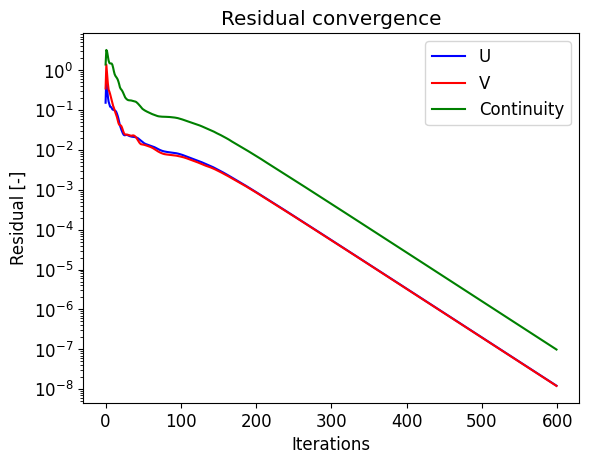

In [520]:

#================ Plotting section ================
# (only examples, more plots might be needed)

# Plot mesh
plt.figure()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Computational mesh\n(reference pressure node marked)')
plt.axis('equal')
plt.vlines(pointX[:,0],pointY[0,0],pointY[0,-1],colors = 'k',linestyles = 'dashed')
plt.hlines(pointY[0,:],pointX[0,0],pointX[-1,0],colors = 'k',linestyles = 'dashed')
plt.plot(nodeX, nodeY, 'ro')
plt.plot(nodeX[pRef_i,pRef_j], nodeY[pRef_i,pRef_j], 'bo')
plt.show()

# Plot velocity vectors
plt.figure()
plt.quiver(nodeX.T, nodeY.T, u.T, v.T)
plt.title('Velocity vectors')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.show()

# Plot u-velocity contour
plt.figure()
tempmap=plt.contourf(nodeX.T,nodeY.T,u.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('$[m/s]$')
plt.title('U velocity $[m/s]$')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot v-velocity contour
plt.figure()
tempmap=plt.contourf(nodeX.T,nodeY.T,v.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('$[m/s]$')
plt.title('V velocity $[m/s]$')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot pressure contour
plt.figure()
tempmap=plt.contourf(nodeX.T,nodeY.T,p.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('$[Pa]$')
plt.plot(nodeX[pRef_i,pRef_j], nodeY[pRef_i,pRef_j], 'bo')
plt.title('Pressure $[Pa]$\n(reference pressure node marked)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot residual convergence
plt.figure()
plt.semilogy(range(0,iter+1), res_u, 'blue', label = 'U')
plt.semilogy(range(0,iter+1), res_v, 'red', label = 'V')
plt.semilogy(range(0,iter+1), res_c, 'green', label = 'Continuity')
plt.title('Residual convergence')
plt.xlabel('Iterations')
plt.ylabel('Residual [-]')
plt.legend()
plt.show()

# Comparison with validation data
match mesh_type:
    case 'equidistant' | 'non-equidistant':
        data_file = 'data/'+scheme+'.txt'
        data=np.genfromtxt(data_file, skip_header=1)
        uInterp = np.zeros((nJ-2,1))
        vInterp = np.zeros((nJ-2,1))
        for j in range(1,nJ-1):
            for i in range(1,nI-1):
                if nodeX[i,j]<=0.5 and nodeX[i+1,j]>0.5:
                    f = (0.5-nodeX[i,j])/dx_PE[i,j]
                    uInterp[j-1] = f*u[i+1,j] + (1-f)*u[i,j]
                    vInterp[j-1] = f*v[i+1,j] + (1-f)*v[i,j]
        plt.figure()
        plt.plot(data[:,0],data[:,2],'r.',markersize=20,label='data U')
        plt.plot(data[:,1],data[:,2],'b.',markersize=20,label='data V')
        plt.plot(uInterp,nodeY[1,1:-1],'k',label='sol U')
        plt.plot(vInterp,nodeY[1,1:-1],'g',label='sol V')
        plt.title('Comparison with data at x = 0.5\n('+scheme+', '+RhieChow+')')
        plt.xlabel('u, v [m/s]')
        plt.ylabel('y [m]')
        plt.legend()
    case 'coarse' | 'fine':
        pass
    case _:
        sys.exit("Improper mesh type!")